# **Procedure Vs. Gender Analytics | Partner Focus Question 1 Notebook**

### **Purpose**
The purpose of this notebook is to explore and address our project partner’s focus question 1, what, if any,  relationship exists between EMS **procedures** performed on a patient given by a provider based on the **gender** of either. This notebook prepares the data and defines the analytics for procedures performed compared to the genders of both patient and provider.
<br>
The dataset used to build the analytics is the intermediate Procedures+Patients merged dataset that was conditioned in a prior data engineering step. The script that creates this dataset also drops duplicates and removes some NULL records.

### **Entrance Criteria**

* The Patients and Procedures dataset from the data/02_intermediate folder is available and read in for the analytics designed and built in this notebook. The resulting intermediate dataset, Procedures+Patients, contains 170,072 rows where each row includes a procedure performed by a provider and given to a patient, including gender information. Each row represents a single instance of an EMS procedure administered to a patient by an EMS provider.

* A second dataset  was created from information provided by the DASM project partner team containing all the procedures mapped to a higher-level category. This reduced the overall count of procedures allowing the plotting and visualization of the analytics more manageable and concise. This reference dataset, ProcedureGroups contains 68 rows and has enrichment data with a Category Label and a Category Code and is merged with the Procedures+Patients intermediate dataset. 

* The duplicate rows related to FRDPersonnelID (Provider Identifier) = 9E5D40DC-5DC6-E411-80C7-001DD8B71D38 are dropped from the Procedures+Patients intermediate dataset. This was indicated to do so by the project team’s partner FCFRD partners.

* Rows in the raw Patients dataset with NULL Provider Gender and Provider Start Date were dropped prior to the joining process. 

* Rows with NULL Patient Gender were retained for the other focus question using this dataset. NULL  Patient Gender rows will need to be removed prior to this analysis.

*Author: Mark Lee*

### **Functions and Imports**

#### **Function to identify and print easy to understand variable types**

In [1]:
def get_var_category(series):
    unique_count = series.nunique(dropna=False)
    total_count = len(series)
    if pd.api.types.is_numeric_dtype(series):
        return 'Numerical'
    elif pd.api.types.is_datetime64_dtype(series):
        return 'Date'
    elif unique_count == total_count:
        return 'Text (Unique)'
    else:
        return 'Categorical'

def print_categories(df):
    for column_name in df.columns:
        print(column_name, ": ", get_var_category(df[column_name]))

#### **Import Python libraries**

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import os, time
import copy

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns
%matplotlib inline

# Setup HTML display
from IPython.core.display import display, HTML
# Notebook cell width adjustment
display(HTML('<style>.container { width:80% !important; }</style>'))

#### **Read in intermediate Procedures+Patients merged dataset**

Parse date columns so Pandas recognizes them as date fields.

In [3]:
dfProcPat = pd.read_csv(r'../data/02_intermediate/ProceduresPatients-Intermediate.csv', parse_dates=['FRDPersonnelStartDate','DispatchTime'])
dfProcPat.shape

(170072, 18)

#### **Read in Procedure category groups**

Read in derived dataset based on procedure groupings provided by partner team. This procedure grouping will ultimately reduce the number of procedure from 67 to 31 and will help make the analysis and visualizations more concise.

In [4]:
dfProcGrp = pd.read_csv(r'../data/02_intermediate/ProcedureGroups.csv')
dfProcGrp.shape

(68, 4)

### **Exploring the datasets**

Check column data types using print_categories() function for both the Procedures+Patients and the Procedure category groups dataset.

In [5]:
print_categories(dfProcPat)

PatientId :  Numerical
FRDPersonnelID :  Categorical
PatientOutcome :  Categorical
PatientGender :  Categorical
DispatchTime :  Date
FRDPersonnelGender :  Categorical
FRDPersonnelStartDate :  Date
Dim_Procedure_PK :  Numerical
Procedure_Performed_Code :  Numerical
Procedure_Performed_Description :  Categorical
_PK :  Categorical
TenureMonths :  Numerical
PatientOutcomeCode :  Numerical
PatientGenderCode :  Numerical
PatientGender_Female :  Numerical
PatientGender_Male :  Numerical
PatientGender_Unknown (Unable to Determine) :  Numerical
ProviderGenderCode :  Numerical


In [6]:
print_categories(dfProcGrp)

Procedure_Performed_Description :  Text (Unique)
Procedure_Performed_Code :  Numerical
CategoryLabel :  Categorical
CategoryCode :  Numerical


#### **Missing values**

Check for full NULL count

In [7]:
dfProcPat.isnull().values.sum()

104

List NULL count by column

In [8]:
dfProcPat.isnull().sum()

PatientId                                        0
FRDPersonnelID                                   0
PatientOutcome                                   0
PatientGender                                  104
DispatchTime                                     0
FRDPersonnelGender                               0
FRDPersonnelStartDate                            0
Dim_Procedure_PK                                 0
Procedure_Performed_Code                         0
Procedure_Performed_Description                  0
_PK                                              0
TenureMonths                                     0
PatientOutcomeCode                               0
PatientGenderCode                                0
PatientGender_Female                             0
PatientGender_Male                               0
PatientGender_Unknown (Unable to Determine)      0
ProviderGenderCode                               0
dtype: int64

There are 104 NULL values for Patient Gender

Check for full NULL count in the procedure category groups file.

In [9]:
dfProcGrp.isnull().values.sum()

0

There are no NULL values for procedure category groups

#### **Unique values**

List of unique values and row count by select categorical columns

In [10]:
print('Patient Outcome Unique Value Count: ', dfProcPat['PatientOutcome'].value_counts().count())
print('Patient Gender Unique Value Count: ', dfProcPat['PatientGender'].value_counts().count())
print('Provider Gender Unique Value Count: ', dfProcPat['FRDPersonnelGender'].value_counts().count())
print('Procedure Performed Desc Unique Value Count: ', dfProcPat['Procedure_Performed_Description'].value_counts().count())
print('Procedure Performed Code Unique Value Count: ', dfProcPat['Procedure_Performed_Code'].value_counts().count())

Patient Outcome Unique Value Count:  9
Patient Gender Unique Value Count:  3
Provider Gender Unique Value Count:  2
Procedure Performed Desc Unique Value Count:  68
Procedure Performed Code Unique Value Count:  67


Looks like there are a couple of issues here: 
- Patient Gender has a 3 count of values
- Procedure Performed Description and Code have values of 68 and 67

This issue with Procedure Performed Description is the source data has the same code for both descriptions of "Airway - Supraglottic Airway (King, i-Gel)" and  "Airway - Supraglottic Airway (i-Gel, King)". So, a replacement will be made.

#### **Replace Procedure Description**

In [11]:
dfProcPat['Procedure_Performed_Description'] = dfProcPat['Procedure_Performed_Description'] \
                                               .replace(['Airway - Supraglottic Airway (King, i-Gel)'],
                                                        'Airway - Supraglottic Airway (i-Gel, King)')

#### **Checking the 3 types of Patient Gender**
List of Patient Gender unique values and row counts

In [12]:
dfProcPat['PatientGender'].value_counts()

Male                             89956
Female                           79942
Unknown (Unable to Determine)       70
Name: PatientGender, dtype: int64

Analysis will require the Patient Gender be known, so need to remove:
- "Unknown (Unable to Determine)" 70 row count (0.04% of the data)
- NULL values 104 row count or (0.06% of the data)

#### **Remove all Patient Gender NULL and Unknown rows**

In [13]:
dfProcPat = dfProcPat.drop(dfProcPat[(dfProcPat.PatientGender.isnull())].index)
dfProcPat.shape

(169968, 18)

In [14]:
dfProcPat = dfProcPat[dfProcPat.PatientGender != 'Unknown (Unable to Determine)']
dfProcPat.shape

(169898, 18)

#### **Analysis for Data Imbalances for Gender Attributes**

With an imbalance of Patient and/or Provider Gender in the data some of the analysis and visualizations distributions will become skewed.

|Individual Id Counts||||||Row Counts||||||
|--||--||--||--||||||
|Patient Gender|||||||
|Female||45,605||49.6%||Female||79,942||47.1%|
|Male||46,421||50.4%||Male||89,956||52.9%|
|Total||92,026||100.0%||Total||169,898||100.0%|
|Provider Gender|||||||
|Female||215||17.1%||Female||29,803||17.5%|
|Male||1,045||82.9%||Male||140,095||82.5%|
|Total||1,260||100.0%||Total||169,898||100.0%|

#### **Create horizontal bar chart of Patient Gender by percentage of individual identifier (ID) count**

In [15]:
patGendCntInv = len(pd.unique(dfProcPat['PatientId']))
dfPatGendInv = dfProcPat.groupby(['PatientId','PatientGender']).count()
dfPatGendInv = dfPatGendInv.groupby(['PatientGender']).size().astype(float).reset_index(name='Count')
dfPatGendInv = dfPatGendInv.assign(Pct = lambda x: (x['Count'] /patGendCntInv * 100))
dfPatGendInv

,PatientGender,Count,Pct
0,Female,45605.0,49.556647
1,Male,46421.0,50.443353


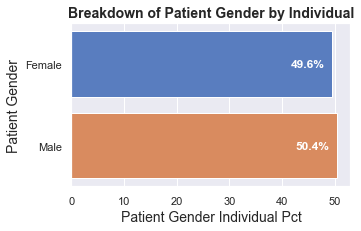

In [16]:
sns.set_theme()
fig, ax = plt.subplots(figsize = (5,3))
ax = sns.barplot(y='PatientGender', 
                 x='Pct', 
                 palette='muted', 
                 data=dfPatGendInv) 
for p in ax.patches:
    height = p.get_height()
    width = p.get_width()
    ax.text(x = width-8,
            y = p.get_y() + (height/2),
            s = "%.1f%%"% p.get_width(),
            color='white',
            fontweight='bold',
            va = 'center') 
ax.set_title('Breakdown of Patient Gender by Individual',
              fontdict={'fontsize': 14,
                        'fontweight':'bold'})
ax.set_xlabel('Patient Gender Individual Pct',fontsize=14)
ax.set_ylabel('Patient Gender',fontsize=14)
plt.show()

#### **Create horizontal bar chart of Patient Gender by percentage of row count**

In [17]:
genderCntTotal = dfProcPat['PatientGender'].count().astype(float)
dfPatGendRow = dfProcPat.groupby(['PatientGender']).size().astype(float).reset_index(name='Count')
dfPatGendRow = dfPatGendRow.assign(Pct = lambda x: (x['Count'] /genderCntTotal * 100))
dfPatGendRow

,PatientGender,Count,Pct
0,Female,79942.0,47.052938
1,Male,89956.0,52.947062


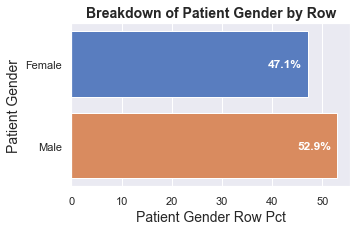

In [18]:
fig, ax = plt.subplots(figsize = (5,3))
ax = sns.barplot(y='PatientGender',
                 x='Pct',
                 palette='muted',
                 data=dfPatGendRow)
for p in ax.patches:
    height = p.get_height()
    width = p.get_width()
    ax.text(x = width-8,
            y = p.get_y() + (height/2),
            s = "%.1f%%"% p.get_width(),
            color='white',
            fontweight='bold',
            va = 'center') 
ax.set_title('Breakdown of Patient Gender by Row',
              fontdict={'fontsize': 14,
                        'fontweight':'bold'})
ax.set_xlabel('Patient Gender Row Pct',fontsize=14)
ax.set_ylabel('Patient Gender',fontsize=14)
plt.show()

#### **Create horizontal bar chart of Provider Gender by percentage of individual identifier (ID) count**

In [19]:
provGendCntInv = len(pd.unique(dfProcPat['FRDPersonnelID']))
dfProvGendInv = dfProcPat.groupby(['FRDPersonnelID','FRDPersonnelGender']).count()
dfProvGendInv = dfProvGendInv.groupby(['FRDPersonnelGender']).size().astype(float).reset_index(name='Count')
dfProvGendInv = dfProvGendInv.assign(Pct = lambda x: (x['Count'] /provGendCntInv * 100))
dfProvGendInv

,FRDPersonnelGender,Count,Pct
0,Female,215.0,17.063492
1,Male,1045.0,82.936508


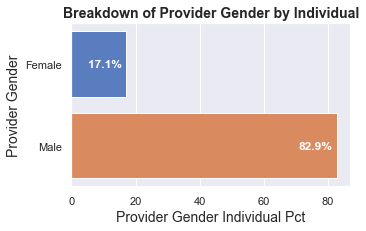

In [20]:
fig, ax = plt.subplots(figsize = (5,3))
ax = sns.barplot(y='FRDPersonnelGender',
                 x='Pct',
                 palette='muted',
                 data=dfProvGendInv)
for p in ax.patches:
    height = p.get_height()
    width = p.get_width()
    ax.text(x = width-12,
            y = p.get_y() + (height/2),
            s = "%.1f%%"% p.get_width(),
            color='white',
            fontweight='bold',
            va = 'center') 
ax.set_title('Breakdown of Provider Gender by Individual',
              fontdict={'fontsize': 14,
                        'fontweight':'bold'})
ax.set_xlabel('Provider Gender Individual Pct',fontsize=14)
ax.set_ylabel('Provider Gender',fontsize=14)
plt.show()

#### **Create horizontal bar chart of Provider Gender by percentage of row count**

In [21]:
# Use the already created genderCntTotal variable
dfProvGendRow = dfProcPat.groupby(['FRDPersonnelGender']).size().astype(float).reset_index(name='Count')
dfProvGendRow = dfProvGendRow.assign(Pct = lambda x: (x['Count'] /genderCntTotal * 100))
dfProvGendRow

,FRDPersonnelGender,Count,Pct
0,Female,29803.0,17.541701
1,Male,140095.0,82.458299


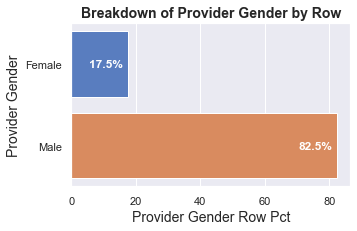

In [22]:
fig, ax = plt.subplots(figsize = (5,3))
ax = sns.barplot(y='FRDPersonnelGender',
                 x='Pct',
                 palette='muted',
                 data=dfProvGendRow)
for p in ax.patches:
    height = p.get_height()
    width = p.get_width()
    ax.text(x = width-12,
            y = p.get_y() + (height/2),
            s = "%.1f%%"% p.get_width(),
            color='white',
            fontweight='bold',
            va = 'center') 
ax.set_title('Breakdown of Provider Gender by Row',
              fontdict={'fontsize': 14,
                        'fontweight':'bold'})
ax.set_xlabel('Provider Gender Row Pct',fontsize=14)
ax.set_ylabel('Provider Gender',fontsize=14)
plt.show()

**Gender Imbalance**<br>
Viewing the charts above, the amount of male to female Patients is relatively balanced with close to 50% each, especially the counts of individual patients. That differs when considering the breakdown of gender by providers, where there is a significant imbalance. In fact, there’s nearly five (5) times as many male providers than female providers. This imbalance is normalized for some of the later analyses.

### **Merge datasets**

#### **Merge Procedures+Patients dataframe with Procedure Groupings dataframe**

In [23]:
dfProcPat = dfProcGrp.merge(dfProcPat, 
                        on=('Procedure_Performed_Description','Procedure_Performed_Code'))
dfProcPat.shape

(169898, 20)

Add a new column that will act as the display for the y-axis summary text and for name of the chart legend.

In [24]:
dfProcPat['ProviderPatientGender'] = 'Provider: ' + dfProcPat['FRDPersonnelGender'] + ' | ' + 'Patient: ' + dfProcPat['PatientGender']

#### **Countplot of procedures categories performed distribution**

Looking for data skewness based on high counts of procedures performed.

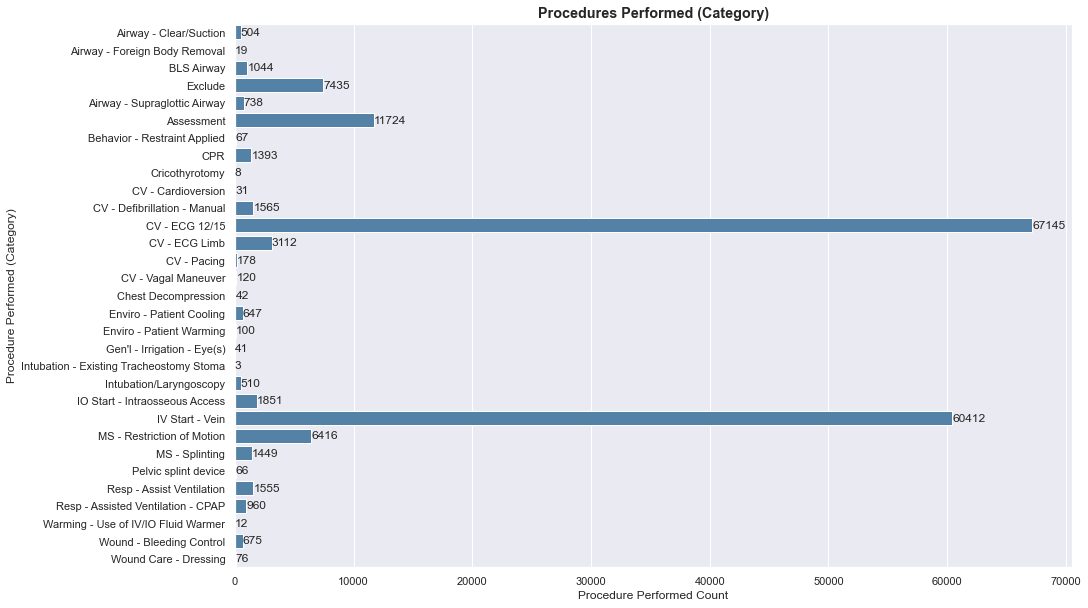

In [25]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.countplot(y='CategoryLabel',
                   color='steelblue',
                   data=dfProcPat)
for p in ax.patches:
    height = p.get_height()
    width = p.get_width()
    ax.text(x = width+1,
            y = p.get_y() + (height/2),
            s = p.get_width(),
            va = 'center') 
ax.set(xlabel='Procedure Performed Count', ylabel='Procedure Performed (Category)')
ax.set_title('Procedures Performed (Category)', fontsize='large', fontweight = 'bold')
#plt.savefig('plot-dist.png')
plt.show()

The category procedures "CV - EG - 12/15" and "IV Start - Vein" are clearly the majority of the procedures

## **Analysis for Procedures Performed Category**

To normalize the gender imbalance of female and male EMS Providers, each Procedure category is broken out by female and male into separate dataframes. Then for each dataframe a percentage is calculated for all counts of Procedures given for both female and male Patients. This will provide a percentage the number of times a Procedure was given to either a female of male Patient, rather than just a count. So, each dataframe sums up to 1 (or 100%). This was tried with a crosstab normalizing for all, but the percentages of male Providers giving certain procedures was much higher than females due to the gender imbalance.

### **Define new dataframes for Provider gender**

In [26]:
dfProviderF = dfProcPat[(dfProcPat.FRDPersonnelGender == 'Female')]
dfProviderM = dfProcPat[(dfProcPat.FRDPersonnelGender == 'Male')]

Reduce dataframe size to only columns necessary for analytics.

Follow up with using a group by and an aggregate function to roll up and count each row for each procedure performed by a female provider to a patient of each gender and then the same thing for male providers.

Then for later analytics, create the percentage of procedures given to patients for female and male providers separately. This will help balance the provider gender data since there are roughly five times as many male providers than there are female providers.

**Gender comparisons**

|Provider Gender||Patient Gender|
|--||--|
|Female||Female|
|Female||Male|
|Male||Female|
|Male||Male|

### **Calculate percentage of Procedure categories**

In [27]:
dfcols = ['FRDPersonnelGender','CategoryLabel','PatientGender','ProviderPatientGender','_PK']
dfProviderF[dfcols]
dfProviderM[dfcols]

dfProviderF = dfProviderF.groupby(['FRDPersonnelGender','CategoryLabel',
                                   'PatientGender','ProviderPatientGender']).agg({'_PK' : 'count'}).reset_index()
dfProviderM = dfProviderM.groupby(['FRDPersonnelGender','CategoryLabel',
                                   'PatientGender','ProviderPatientGender']).agg({'_PK' : 'count'}).reset_index()

dfProviderF.rename(columns = {'_PK':'ProcedurePct', 'FRDPersonnelGender':'ProviderGender'}, inplace = True)
dfProviderM.rename(columns = {'_PK':'ProcedurePct', 'FRDPersonnelGender':'ProviderGender'}, inplace = True)

dfProviderFPct = dfProviderF.groupby(['ProviderGender','CategoryLabel',
                                      'PatientGender','ProviderPatientGender'])["ProcedurePct"].sum()
dfProviderFPct = (dfProviderFPct / dfProviderFPct.groupby(level=[0]).transform("sum")) * 100

dfProviderF = dfProviderFPct.reset_index()
print(type(dfProviderF))

dfProviderMPct = dfProviderM.groupby(['ProviderGender','CategoryLabel',
                                      'PatientGender','ProviderPatientGender'])["ProcedurePct"].sum()
dfProviderMPct = (dfProviderMPct / dfProviderMPct.groupby(level=[0]).transform("sum")) * 100

dfProviderM = dfProviderMPct.reset_index()
print(type(dfProviderM))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [28]:
dfProviderF.head(3)

,ProviderGender,CategoryLabel,PatientGender,ProviderPatientGender,ProcedurePct
0,Female,Airway - Clear/Suction,Female,Provider: Female | Patient: Female,0.114082
1,Female,Airway - Clear/Suction,Male,Provider: Female | Patient: Male,0.204677
2,Female,Airway - Foreign Body Removal,Female,Provider: Female | Patient: Female,0.003355


Concatenate the male and female providers matrices that will be used to display the analysis (created similar to crosstabs, but they don’t normalize by groupings, only all, column, row)

In [29]:
dfProcConcat = pd.concat([dfProviderF, dfProviderM])
print(type(dfProcConcat))

<class 'pandas.core.frame.DataFrame'>


#### **Create a horizontal grouped bar chart**

This horizontal grouped bar chart will display the four variations of provider and patient gender combinations and show a percentage for each for comparison. This chart is run on all procedures before any groupings. Subsequent renderings are run with grouping provided by our project partner.

NOTE: There are many procedures that have not been performed by or on each gender. This accounts for many missing values on the chart and for the posted errors "posx and posy should be finite values".

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


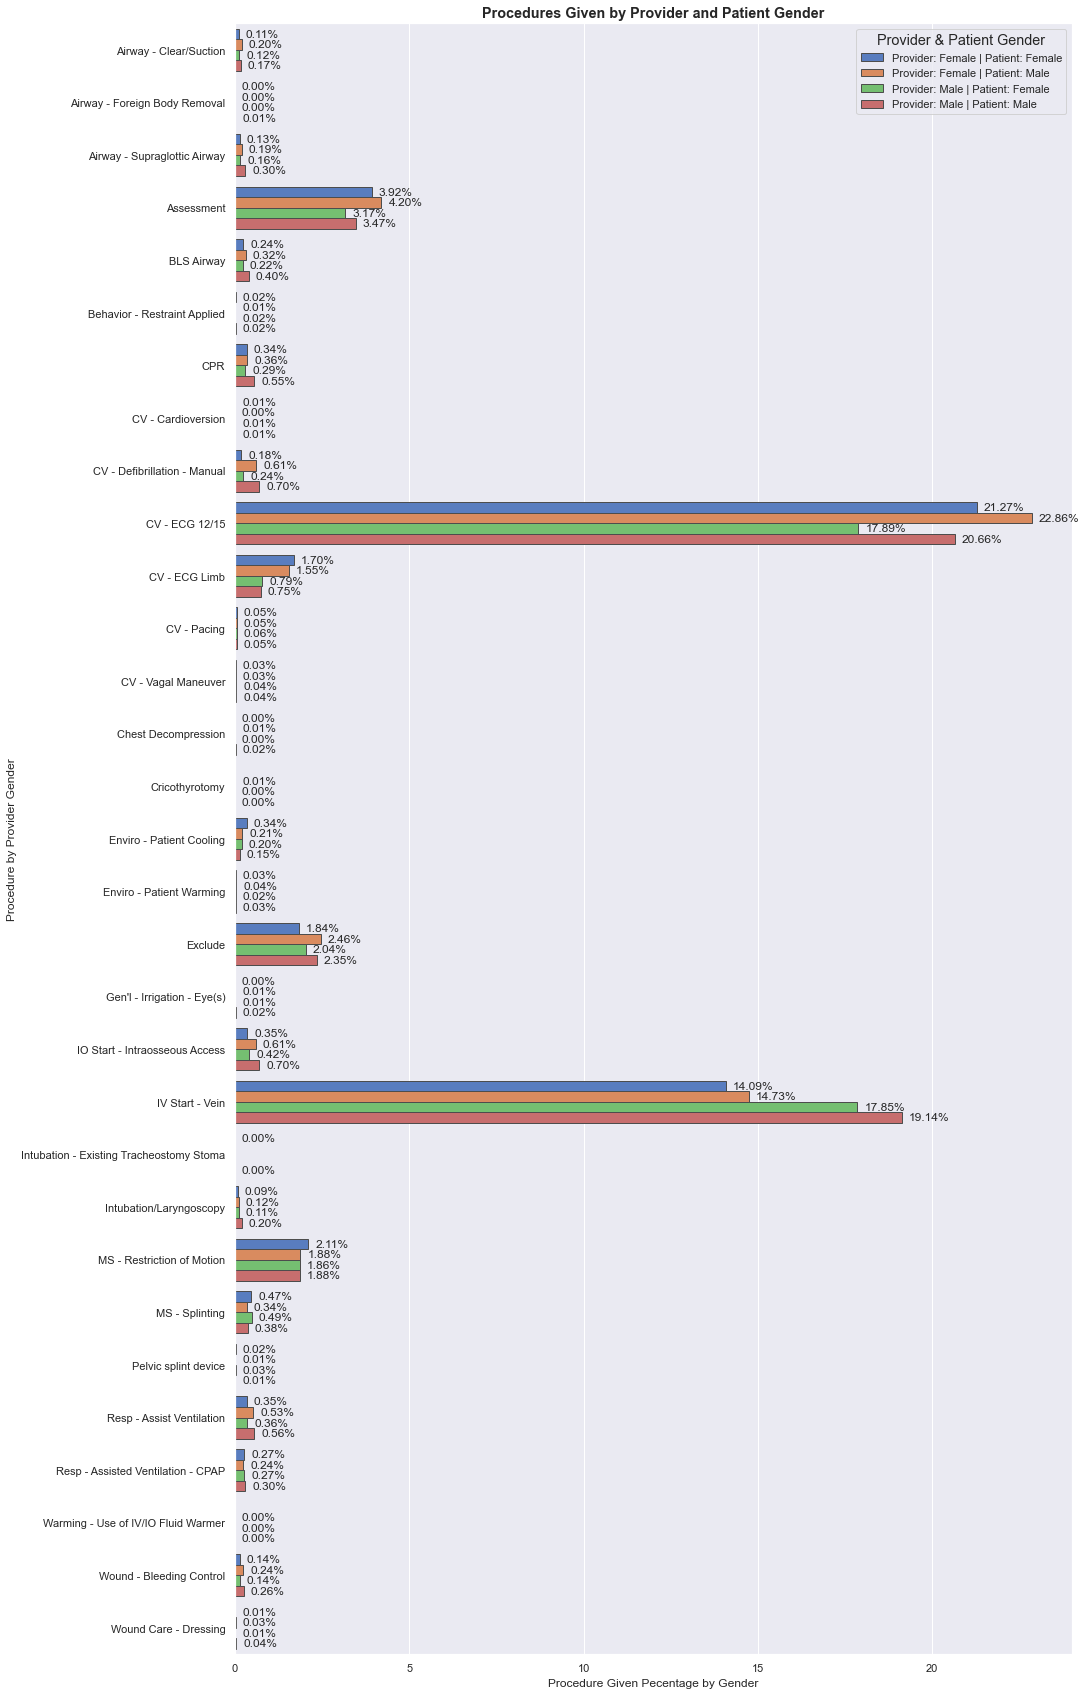

In [30]:
fig, ax = plt.subplots(figsize=(15, 30))
ax = sns.barplot(x='ProcedurePct', 
                 y='CategoryLabel', 
                 hue='ProviderPatientGender',
                 palette='muted',
                 edgecolor=".3",
                 data=dfProcConcat) 
for p in ax.patches:
    height = p.get_height()
    width = p.get_width()
    ax.text(x = width+.2,
            y = p.get_y() + (height/2),
            s = "%.2f%%"% p.get_width(),
            va = 'center')
ax.legend(title='Provider & Patient Gender', title_fontsize='large', loc='best')
ax.set(xlabel='Procedure Given Pecentage by Gender', ylabel='Procedure by Provider Gender')
ax.set_title('Procedures Given by Provider and Patient Gender', fontsize='large', fontweight = 'bold')
#plt.savefig('plot-diff-all.png')
plt.show()

#### **Plot Differences**

After reviewing the comparison chart, it seemed appropriate considering some of the percentages were so small, to create a variation comparison chart of all the percentage differences. Making these comparisons requires to check the differences between all four (4) types. By comparing all four (4) types, this now requires six (6) difference calculations by subtracting all the types from one another (similar to a conditional probability table). Doing this in an organized and meaningful way requires following the same pattern of subtraction seen in the table below. Doing so begins similar to the way the comparison chart was developed, with a new dataframe created for each female and male. 

| Provider || Patient || Subtract || Provider || Patient |
|--||--||--||--||--|
|Female||Female|| Minus ||Female||Male|
|Female||Male|| Minus ||Male||Female|
|Male||Female|| Minus ||Male||Male|
|Female||Female|| Minus ||Male||Female|
|Female||Female|| Minus ||Male||Male|
|Female||Male|| Minus ||Female||Male|

These percentage differences are then plotted similar to the comparisons chart with six (6) grouped bars based on all differences between the original four (4) provider and patient gender combinations. The highest differences are with “CV - ECG 12/15”, “Assessment”, “IV Start - Vein”.<br>
Create pivot table.

In [31]:
dfDistDiffPivot = dfProcConcat.pivot_table(index=['CategoryLabel'],
                                      columns=['ProviderPatientGender'],
                                      values=['ProcedurePct'],
                                      aggfunc=lambda x: ' '.join(str(v) for v in x),
                                      fill_value=0)

In [32]:
dfDistDiffPivot.head(3)

ProcedurePct  \
ProviderPatientGender         Provider: Female | Patient: Female   
CategoryLabel                                                      
Airway - Clear/Suction                       0.11408247491863235   
Airway - Foreign Body Removal              0.0033553669093715397   
Airway - Supraglottic Airway                  0.1342146763748616   

                                                                \
ProviderPatientGender         Provider: Female | Patient: Male   
CategoryLabel                                                    
Airway - Clear/Suction                     0.20467738147166392   
Airway - Foreign Body Removal            0.0033553669093715397   
Airway - Supraglottic Airway                0.1946112807435493   

                                                                \
ProviderPatientGender         Provider: Male | Patient: Female   
CategoryLabel                                                    
Airway - Clear/Suction                     0.12420143474071166   
Airway - Foreign Body Removal             0.004282808094507299   
Airway - Supraglottic Airway               0.16131910489310824   

                                                              
ProviderPatientGender         Provider: Male | Patient: Male  
CategoryLabel                                                 
Airway - Clear/Suction                    0.1677433170348692  
Airway - Foreign Body Removal           0.007851814839930048  
Airway - Supraglottic Airway              0.2955137585210036

In [33]:
print(type(dfDistDiffPivot))

<class 'pandas.core.frame.DataFrame'>


- Flatten the pivot table
- Rename columns
- Change string values back to numeric

In [34]:
dfDistDiff = pd.DataFrame(dfDistDiffPivot.to_records())
dfDistDiff.rename(columns = {"('ProcedurePct', 'Provider: Female | Patient: Female')":'FF',
                             "('ProcedurePct', 'Provider: Female | Patient: Male')":'FM',
                             "('ProcedurePct', 'Provider: Male | Patient: Female')":'MF',
                             "('ProcedurePct', 'Provider: Male | Patient: Male')":'MM'}, inplace = True) 
print("\nAfter modifying first column:\n", dfDistDiff.columns)

dfDistDiff['FF'] = dfDistDiff['FF'].astype(float)
dfDistDiff['FM'] = dfDistDiff['FM'].astype(float)
dfDistDiff['MF'] = dfDistDiff['MF'].astype(float)
dfDistDiff['MM'] = dfDistDiff['MM'].astype(float)


After modifying first column:
 Index(['CategoryLabel', 'FF', 'FM', 'MF', 'MM'], dtype='object')


In [35]:
print_categories(dfDistDiff)

CategoryLabel :  Text (Unique)
FF :  Numerical
FM :  Numerical
MF :  Numerical
MM :  Numerical


In [36]:
dfDistDiff.head(3)

,CategoryLabel,FF,FM,MF,MM
0,Airway - Clear/Suction,0.114082,0.204677,0.124201,0.167743
1,Airway - Foreign Body Removal,0.003355,0.003355,0.004283,0.007852
2,Airway - Supraglottic Airway,0.134215,0.194611,0.161319,0.295514


Create six (6) differences columns

In [37]:
dfDistDiff['FF-FM'] = dfDistDiff['FF'] - dfDistDiff['FM']
dfDistDiff['FM-MF'] = dfDistDiff['FM'] - dfDistDiff['MF']
dfDistDiff['MF-MM'] = dfDistDiff['MF'] - dfDistDiff['MM']
dfDistDiff['FF-MF'] = dfDistDiff['FF'] - dfDistDiff['MF']
dfDistDiff['FF-MM'] = dfDistDiff['FF'] - dfDistDiff['MM']
dfDistDiff['FM-MM'] = dfDistDiff['FM'] - dfDistDiff['MM']

In [38]:
dfDistDiff.head(3)

,CategoryLabel,FF,FM,MF,MM,FF-FM,FM-MF,MF-MM,FF-MF,FF-MM,FM-MM
0,Airway - Clear/Suction,0.114082,0.204677,0.124201,0.167743,-0.090595,0.080476,-0.043542,-0.010119,-0.053661,0.036934
1,Airway - Foreign Body Removal,0.003355,0.003355,0.004283,0.007852,0.000000,-0.000927,-0.003569,-0.000927,-0.004496,-0.004496
2,Airway - Supraglottic Airway,0.134215,0.194611,0.161319,0.295514,-0.060397,0.033292,-0.134195,-0.027104,-0.161299,-0.100902


Drop FF, FM, MF, MM columns as we no longer need them for plot data.

In [39]:
dfDistDiff = dfDistDiff.drop(['FF','FM','MF','MM'],axis=1)

Melt the dataframe (Unpivot).

In [40]:
dfDistDiff = dfDistDiff.melt(id_vars=['CategoryLabel'], var_name='ProviderPatient', value_name='diff')

In [41]:
dfDistDiff.head(3)

,CategoryLabel,ProviderPatient,diff
0,Airway - Clear/Suction,FF-FM,-0.090595
1,Airway - Foreign Body Removal,FF-FM,0.000000
2,Airway - Supraglottic Airway,FF-FM,-0.060397


#### **Create a horizontal grouped bar chart to plot Differences**

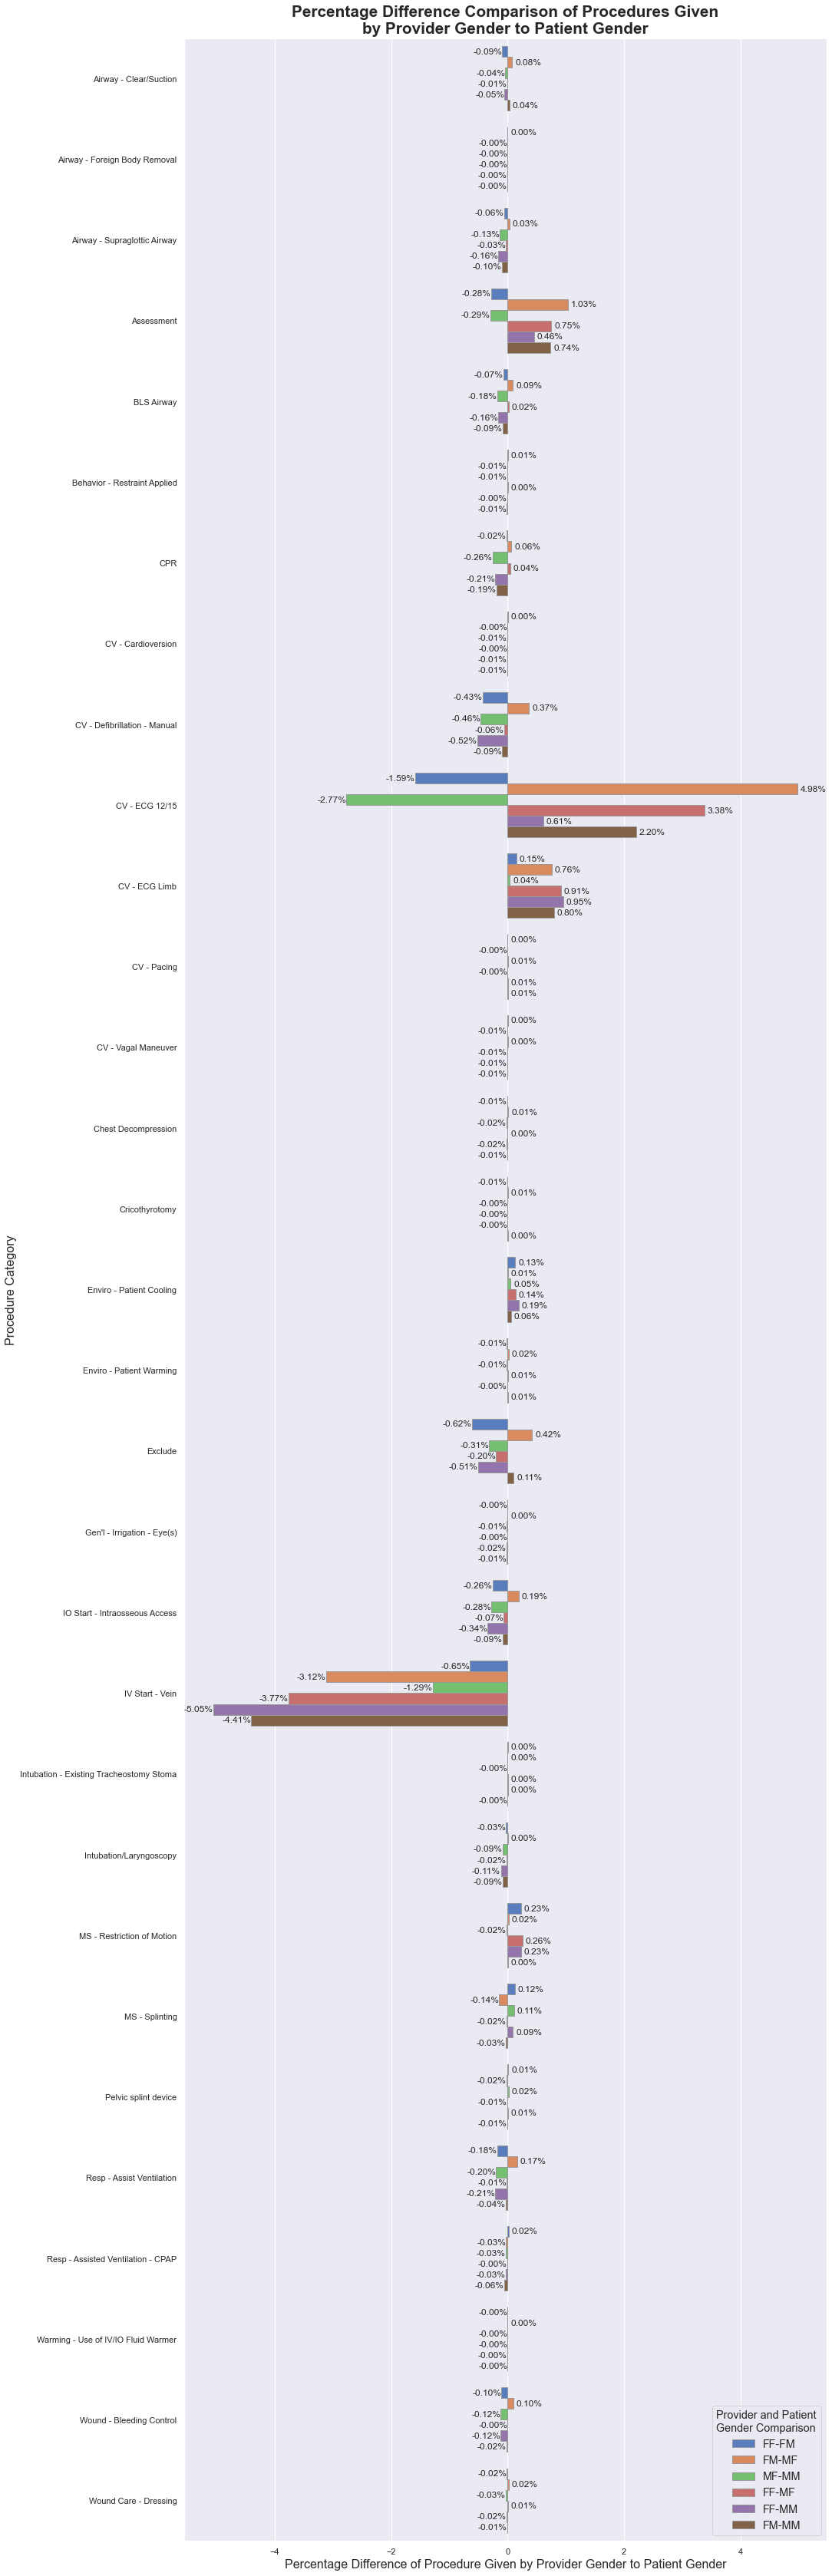

In [42]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(15, 60))
ax = sns.barplot(x='diff', 
                 y='CategoryLabel', 
                 hue='ProviderPatient',
                 palette='muted',
                 edgecolor=".6",
                 data=dfDistDiff) 
for p in ax.patches:
    height = p.get_height()
    width = p.get_width()
    if width >= 0:
        ax.text(x = width+.05,
                 y = p.get_y() + (height/2),
                 s = "%.2f%%"% p.get_width(),
                va = 'center')
    else:
        ax.text(x = width-.5,
                 y = p.get_y() + (height/2),
                 s = "%.2f%%"% p.get_width(),
                va = 'center')
ax.legend(title='Provider and Patient\nGender Comparison', title_fontsize='large', fontsize='large', loc=4)
plt.xlabel('Percentage Difference of Procedure Given by Provider Gender to Patient Gender', fontsize=16)
plt.ylabel('Procedure Category', fontsize=16)
ax.set_title('Percentage Difference Comparison of Procedures Given\nby Provider Gender to Patient Gender', fontsize= 'xx-large', fontweight = 'bold')
#plt.savefig('plot-pct-diff-all.png')
plt.show()

Create modified plots for reseach paper diagrams.

In [43]:
filterDiff2 = dfDistDiff['CategoryLabel'].isin(['CV - ECG 12/15','IV Start - Vein'])
dfDistDiff2 = dfDistDiff[filterDiff2]
dfDistDiff2.sort_values(by=['CategoryLabel','ProviderPatient'])
dfDistDiff2.shape

(12, 3)

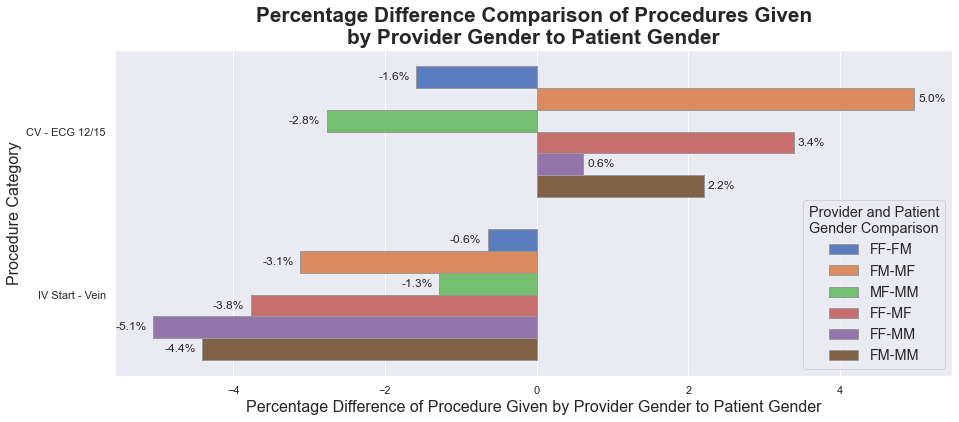

In [44]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(15, 6))
ax = sns.barplot(x='diff', 
                 y='CategoryLabel', 
                 hue='ProviderPatient',
                 palette='muted',
                 edgecolor=".6",
                 data=dfDistDiff2) 
for p in ax.patches:
    height = p.get_height()
    width = p.get_width()
    if width >= 0:
        ax.text(x = width+.05,
                 y = p.get_y() + (height/2),
                 s = "%.1f%%"% p.get_width(),
                va = 'center')
    else:
        ax.text(x = width-.5,
                 y = p.get_y() + (height/2),
                 s = "%.1f%%"% p.get_width(),
                va = 'center')
ax.legend(title='Provider and Patient\nGender Comparison', title_fontsize='large', fontsize='large', loc=4)
plt.xlabel('Percentage Difference of Procedure Given by Provider Gender to Patient Gender', fontsize=16)
plt.ylabel('Procedure Category', fontsize=16)
ax.set_title('Percentage Difference Comparison of Procedures Given\nby Provider Gender to Patient Gender', fontsize= 'xx-large', fontweight = 'bold')
#plt.savefig('plot-diff-present.png')
plt.show()

#### **Create Boxen Plot to examine distribution and identify individual outliers**

To identify potential outliers, Boxen Plots are used for each procedure category to examine the distribution of each provider and patient gender combination. The outliers would indicate if an individual provider, female or male, are providing a treatment procedure to a male or female patient more, or even less, than other individuals against the median. Boxen plots are a great visualization method to display the frequency distributions of larger datasets. 

To use catplot (category plot) with boxen plots, it looks like there are several logical groupings for ideal display:
- CV - ECG and IV Start - Vein
- MS - Restriction of Motion, Assessment, and Exclude
- All others

Looking for outliers with Boxen Plots

Create dataframe for first set of boxen plots

In [45]:
filterBP1 = dfProcPat['CategoryLabel'].isin(['CV - ECG 12/15','IV Start - Vein','Assessment'])
dfProcPatBP1 = dfProcPat[filterBP1]
dfProcPatBP1.shape

(139281, 21)

In [46]:
# Create a new dataframe to define data needed for boxenplots
dfProcPatBP1 = dfProcPatBP1.groupby(['CategoryLabel','ProviderPatientGender','FRDPersonnelID']).size().reset_index(name='IDcount')
dfProcPatBP1.shape

(3740, 4)

Create dataframe for second set of boxen plots

In [47]:
filterBP2 = dfProcPat['CategoryLabel'].isin(['CV - ECG Limb','MS - Restriction of Motion','Exclude'])
dfProcPatBP2 = dfProcPat[filterBP2]
dfProcPatBP2.shape

(16963, 21)

In [48]:
# Create a new dataframe to define data needed for boxenplots
dfProcPatBP2 = dfProcPatBP2.groupby(['CategoryLabel','ProviderPatientGender','FRDPersonnelID']).size().reset_index(name='IDcount')
dfProcPatBP2.shape

(2562, 4)

Create dataframe for third set of boxen plots

In [49]:
filterBP3 = dfProcPat['CategoryLabel'].isin(['CV - Defibrillation - Manual','Enviro - Patient Cooling',
                                             'MS - Splinting','Wound - Bleeding Control'])
dfProcPatBP3 = dfProcPat[filterBP3]
dfProcPatBP3.shape

(4336, 21)

In [50]:
# Create a new dataframe to define data needed for boxenplots
dfProcPatBP3 = dfProcPatBP3.groupby(['CategoryLabel','ProviderPatientGender','FRDPersonnelID']).size().reset_index(name='IDcount')
dfProcPatBP3.shape

(1679, 4)

Create dataframe for fourth set of boxen plots

In [51]:
filterBP4 = ~dfProcPat['CategoryLabel'].isin(['CV - ECG 12/15','CV - ECG Limb','IV Start - Vein','MS - Restriction of Motion','Assessment','Exclude',
                                              'CV - Defibrillation - Manual','Enviro - Patient Cooling','MS - Splinting',
                                              'Wound - Bleeding Control'])
dfProcPatBP4 = dfProcPat[filterBP4]
dfProcPatBP4.shape

(9318, 21)

In [52]:
# Create a new dataframe to define data needed for boxenplots
dfProcPatBP4 = dfProcPatBP4.groupby(['CategoryLabel','ProviderPatientGender','FRDPersonnelID']).size().reset_index(name='IDcount')
dfProcPatBP4.shape

(5078, 4)

Plot and output boxen plots.

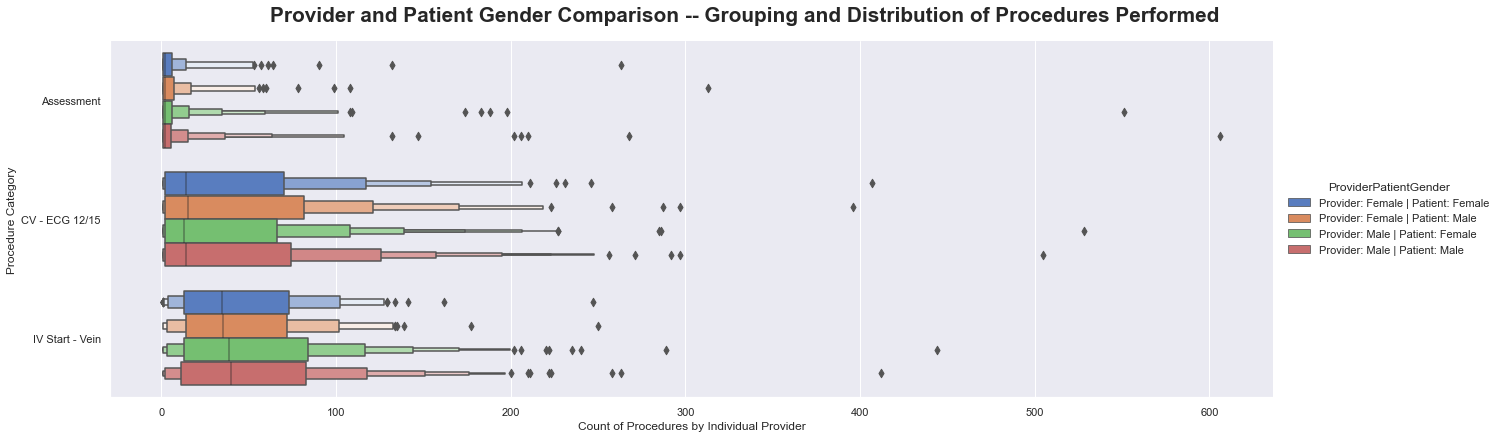

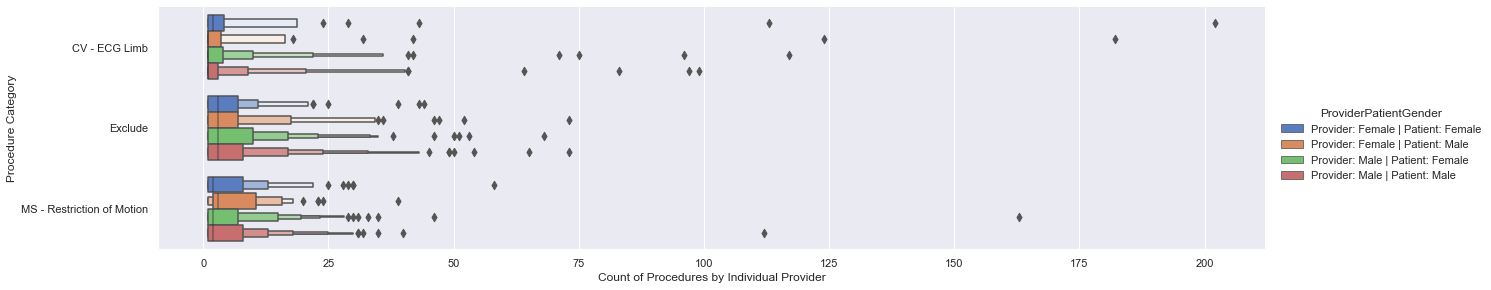

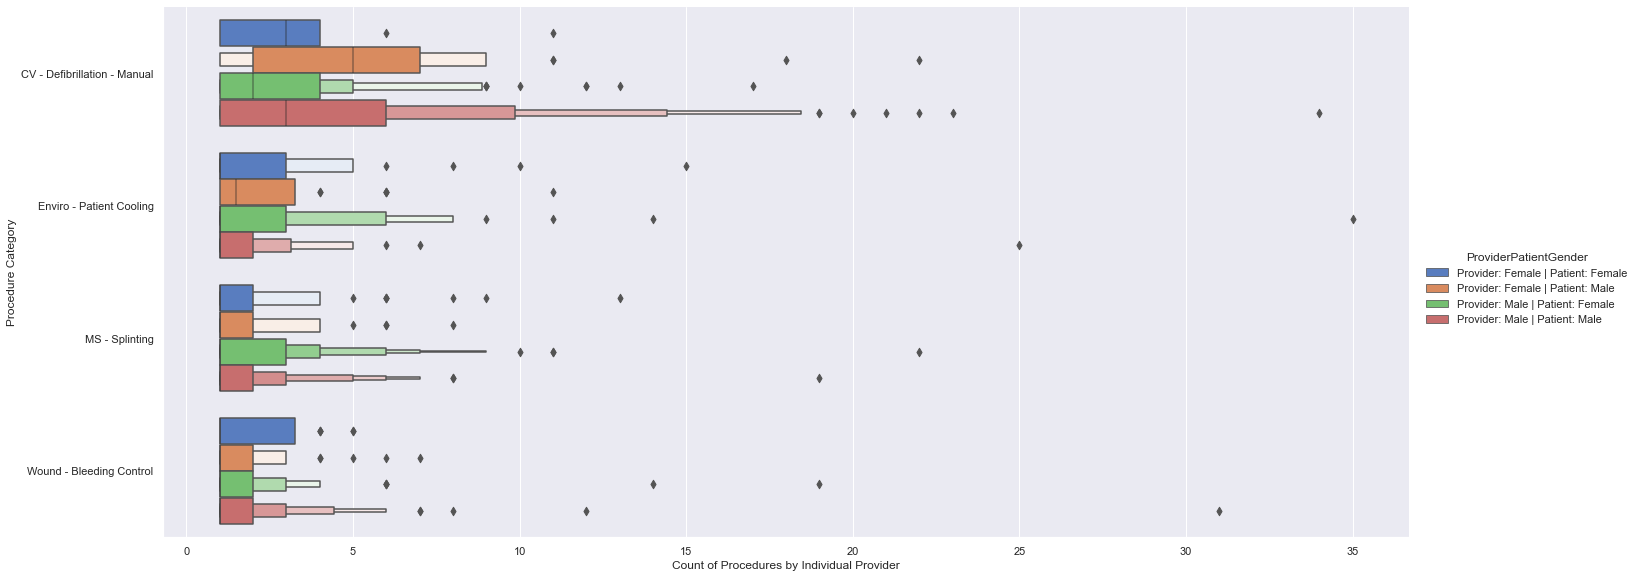

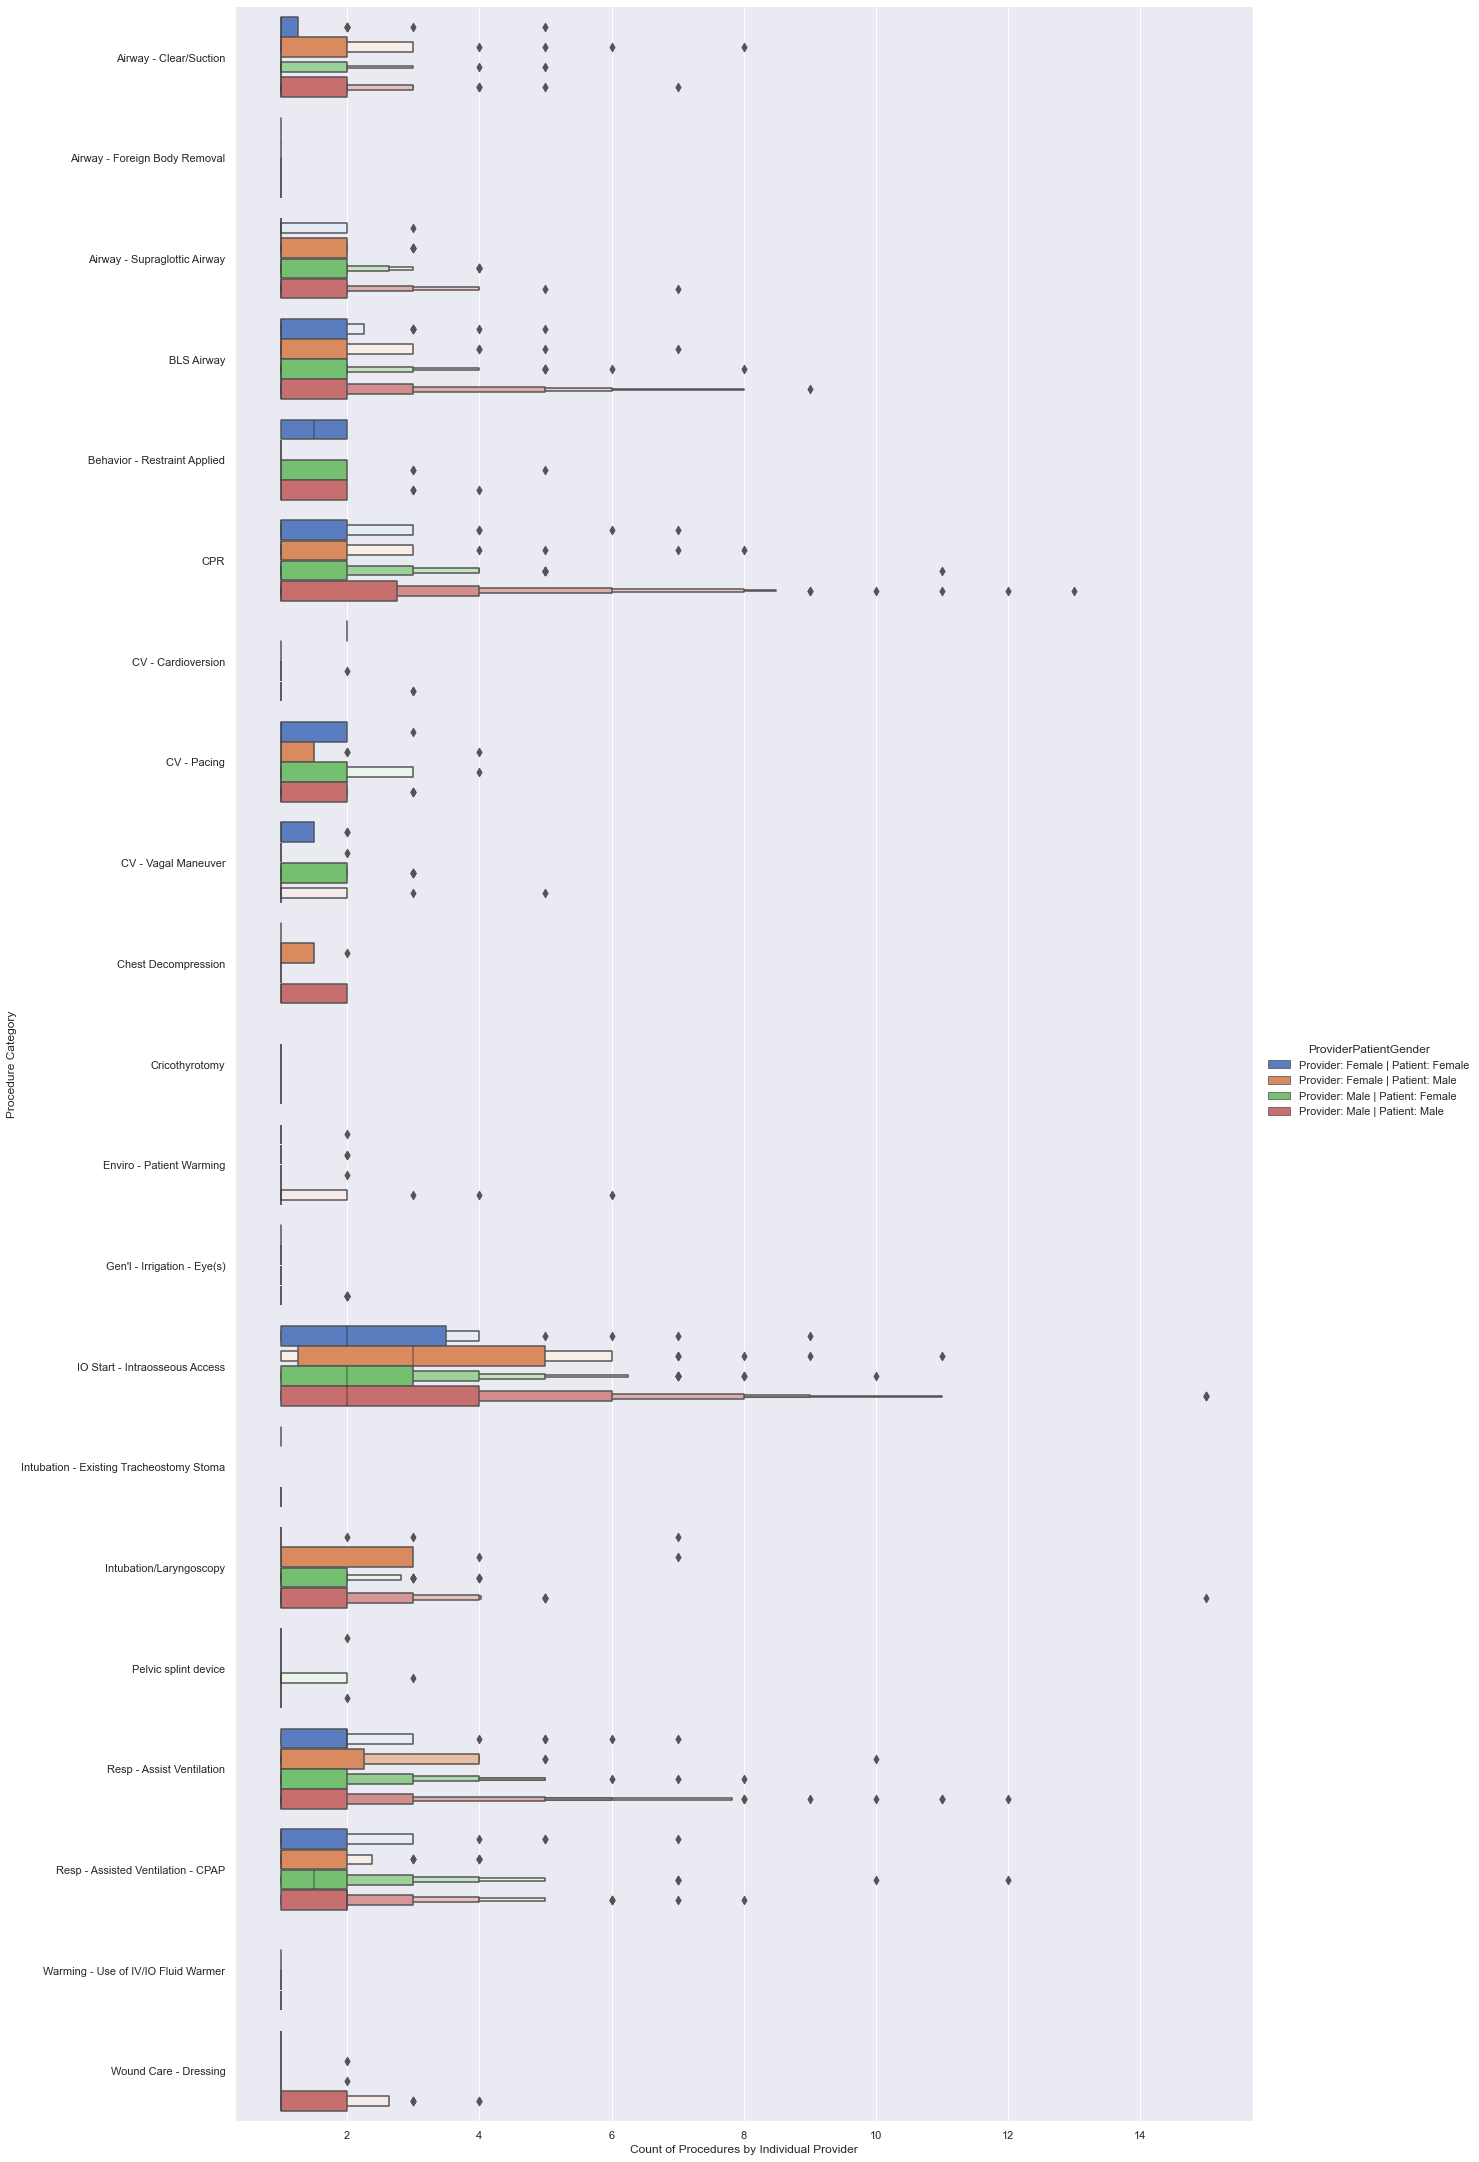

In [53]:
sns.set_theme()
g = sns.catplot(x="IDcount", 
                 y="CategoryLabel",
                 hue="ProviderPatientGender", 
                 data=dfProcPatBP1, kind="boxen",
                 palette='muted',
                 height=6, aspect=3)
g.fig.suptitle("Provider and Patient Gender Comparison -- Grouping and Distribution of Procedures Performed" ,
               fontsize='xx-large', 
               fontweight = 'bold')
g.fig.subplots_adjust(top = 0.90)
g.set_axis_labels('Count of Procedures by Individual Provider','Procedure Category')

g = sns.catplot(x="IDcount", 
                y="CategoryLabel",
                hue="ProviderPatientGender", 
                data=dfProcPatBP2, kind="boxen",
                palette='muted',
                height=4, aspect=4.5)
g.set_axis_labels('Count of Procedures by Individual Provider','Procedure Category')

g = sns.catplot(x="IDcount", 
                y="CategoryLabel",
                hue="ProviderPatientGender", 
                data=dfProcPatBP3, kind="boxen",
                palette='muted',
                height=8, aspect=2.5)
g.set_axis_labels('Count of Procedures by Individual Provider','Procedure Category')

g = sns.catplot(x="IDcount", 
                y="CategoryLabel",
                hue="ProviderPatientGender", 
                data=dfProcPatBP4, kind="boxen",
                palette='muted',
                height=30, aspect=.6)
g.set_axis_labels('Count of Procedures by Individual Provider','Procedure Category')
#plt.savefig('boxen-plot-all.png')
plt.show()

The main purpose of creating these charts was to identify individual provider outliers, which it does as displays of diamond shapes, but it also shows variances in each EMS procedure compared to provider, patient, and gender. The boxen plots visualization also provides the median, plus the lower and upper fourths and the data density for each procedure, provider, and patient combination, as seen in the chart above. This boxen plots visualization acts as a dashboard or as a set of gauges, and the medians are there as an indicator as well as a side-by-side comparison with the grouped plots.

#### **Boxen plots for presentation**

Boxen plot for CV - ECG 12/15

In [54]:
filterBP_ECG = dfProcPat['CategoryLabel'].isin(['CV - ECG 12/15'])
dfProcPatBP_ECG = dfProcPat[filterBP_ECG]
dfProcPatBP_ECG = dfProcPatBP_ECG.groupby(['CategoryLabel','ProviderPatientGender','FRDPersonnelID']).size().reset_index(name='IDcount')
dfProcPatBP_ECG.shape

(1524, 4)

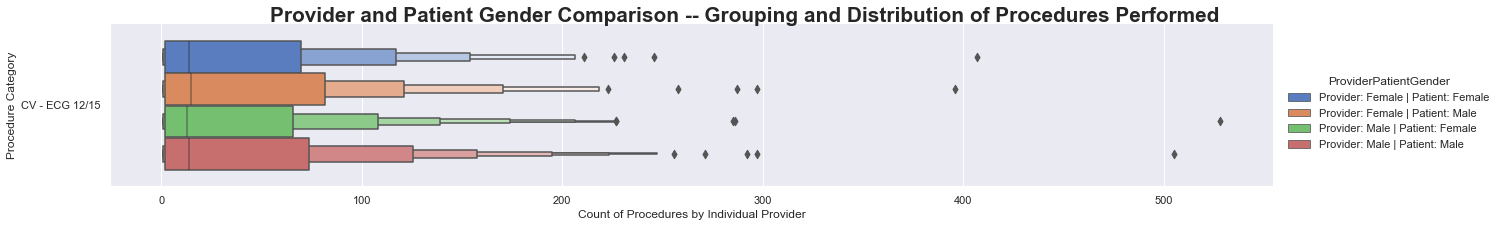

In [55]:
sns.set_theme()
g = sns.catplot(x="IDcount", 
                y="CategoryLabel",
                hue="ProviderPatientGender", 
                data=dfProcPatBP_ECG, 
                kind="boxen",
                palette='muted',
                height=3, aspect=6)
g.fig.suptitle("Provider and Patient Gender Comparison -- Grouping and Distribution of Procedures Performed" ,
               fontsize='xx-large', 
               fontweight = 'bold')
g.fig.subplots_adjust(top = 0.90)
g.set_axis_labels('Count of Procedures by Individual Provider','Procedure Category')
#plt.savefig('boxen-plt-ecg.png')
plt.show()

Boxen plot for 

In [56]:
filterBP_Defib = dfProcPat['CategoryLabel'].isin(['CV - Defibrillation - Manual'])
dfProcPatBP_Defib = dfProcPat[filterBP_Defib]
dfProcPatBP_Defib = dfProcPatBP_Defib.groupby(['CategoryLabel','ProviderPatientGender','FRDPersonnelID']).size().reset_index(name='IDcount')
dfProcPatBP_Defib.shape

(368, 4)

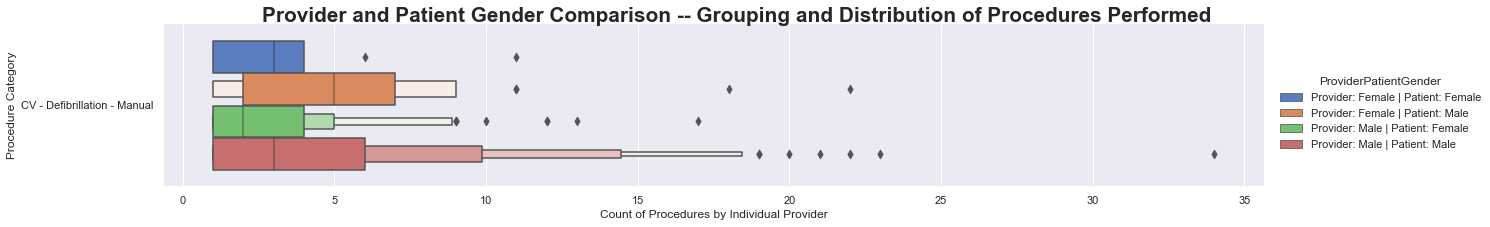

In [57]:
sns.set_theme()
g = sns.catplot(x="IDcount", 
                y="CategoryLabel",
                hue="ProviderPatientGender", 
                data=dfProcPatBP_Defib, 
                kind="boxen",
                palette='muted',
                height=3, aspect=6)
g.fig.suptitle("Provider and Patient Gender Comparison -- Grouping and Distribution of Procedures Performed" ,
               fontsize='xx-large', 
               fontweight = 'bold')
g.fig.subplots_adjust(top = 0.90)
g.set_axis_labels('Count of Procedures by Individual Provider','Procedure Category')
#plt.savefig('boxen-plt-defib.png')
plt.show()